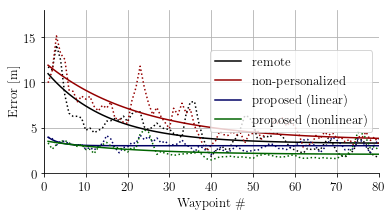

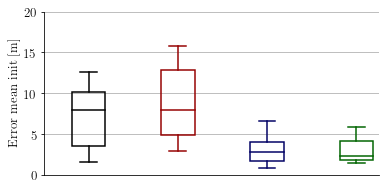

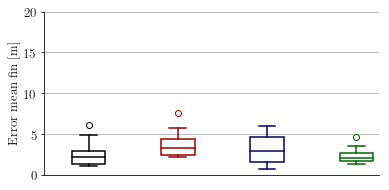

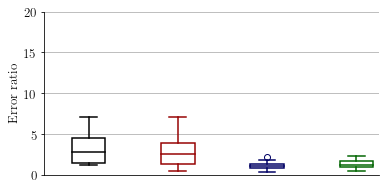

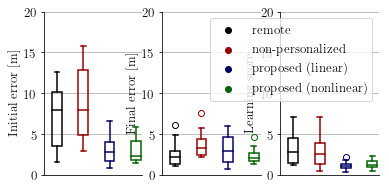

In [10]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 16:11:26 2019

@author: macchini
"""

import ExperimentalDataResults_TEST
import numpy as np
from scipy import optimize
from scipy import stats
from matplotlib.pylab import savefig
import utils
import my_plots

import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy.random import seed
from numpy.random import randn
from scipy.stats import kruskal

### Parameters
    
c0 = np.array([0,0,0])/256
c1 = np.array([150,0,0])/256
c2 = np.array([0,0,100])/256
c3 = np.array([0,100,0])/256

c = [c0, c1, c2, c3]


lw = 1.5

fs = 13

params = {
    'axes.labelsize': fs,
    'font.size': fs,
    'legend.fontsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'text.usetex': False,
    'figure.figsize': [6, 3],
    'boxplot.boxprops.linewidth' : lw,
    'boxplot.whiskerprops.linewidth' : lw,
    'boxplot.capprops.linewidth' : lw,
    'boxplot.medianprops.linewidth' : lw,
    'text.usetex' : True,
    'font.family' : 'serif',

   }
mpl.rcParams.update(params)


settings = ExperimentalDataResults_TEST.initialize_settings()

settings['metric'] = 'error'
settings['run_av_window'] = 3
settings['plot_style'] = 'mean-max-min'
settings['plot'] = False

settings_list = [dict(settings), dict(settings), dict(settings), dict(settings)]

settings_list[0]['interfaces'] = ['remote']
settings_list[0]['methods'] = ['simple']

settings_list[1]['interfaces'] = ['motive']
settings_list[1]['methods'] = ['simple']

settings_list[2]['interfaces'] = ['motive']
settings_list[2]['methods'] = ['maxmin']

settings_list[3]['interfaces'] = ['motive']
settings_list[3]['methods'] = ['new']


names = ['remote', 'simple', 'maxmin', 'new']

result_data = {}

means = {}
means_reduced = {}
std_reduced = {}
means_reduced_all = {}

distr = {}

lim = 40        # first run
one_min = 18    # first minute
lim_fin = 80

for idx,i in enumerate(settings_list):
    
    temp = ExperimentalDataResults_TEST.run_data_results_analysis(i)
    means[names[idx]] = temp.mean[:lim_fin]
    
    means_reduced[names[idx]] = temp.mean[:one_min]
    std_reduced[names[idx]] = temp.std[:one_min]
    
    means_reduced_all[names[idx]] = temp.all_perf
    
    
# fit
    
x_axis = np.arange(len(means['remote']))+1

par = {}

for i in names:
    
    par[i], _ = optimize.curve_fit(lambda t,a,b,c: c+a*np.exp(b*t),  x_axis,  means[i], p0=(5, -0.5, 5), maxfev=10000)
    
# plot all
plt.figure()

ax = plt.subplot(111)

labels = ['remote', 'non-personalized', 'proposed (linear)', 'proposed (nonlinear)' ]

vert = [one_min, lim_fin-one_min]
vert_B = [lim_fin/2]

grey = np.array([1,1,1]) * 0.5

for idx,i in enumerate(names):
    
    ax.plot(x_axis, par[i][2]+par[i][0]*np.exp(x_axis*par[i][1]), label = labels[idx], color = c[idx])
    
    ax.plot(x_axis, means[i], color = c[idx], linestyle = ':')
    
#    for i in vert:
        
#        ax.plot([i,i], [0, 30], color = grey, linewidth = 1, linestyle = '--')
        
    
plt.ylim([0, 18])
plt.xlim([0, lim_fin])
plt.yticks([0, 5, 10, 15])
#plt.xticks([])
    
plt.xlabel('Waypoint \#')
plt.ylabel('Error [m]') #  average on 20 waypoints'

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='center right')
plt.grid()

savefig('../../a2019a_wearableForAerial/Paper/figures/performance_plot.pdf', bbox_inches='tight')
savefig('./performance_plot.pdf', bbox_inches='tight')

mean_mean = {x : np.mean(means_reduced[x]) for x in means_reduced.keys()}
std_mean = {x : np.mean(std_reduced[x]) for x in std_reduced.keys()}

keys_toplot = list(means_reduced.keys())

mean_mean_toplot = [[x] for x in list(mean_mean.values())]
std_mean_toplot = [[x] for x in list(std_mean.values())]


means_init_av = {}

for i in names:
    bau = means_reduced_all[i][:one_min,:]
    means_init_av[i] = np.mean(bau, axis = 0)
    
means_fin_av = {}

for i in names:
    bau = means_reduced_all[i][-one_min:,:]
    means_fin_av[i] = np.mean(bau, axis = 0)
    
means_learn_av = {}

for i in names:
    bau = means_reduced_all[i][:one_min,:]
    bau1 = means_reduced_all[i][-one_min:,:]
    bau_m = np.mean(bau, axis = 0)
    bau1_m = np.mean(bau1, axis = 0)
    learn = bau_m/bau1_m
    means_learn_av[i] = learn
    
    
mean_learn = {x : np.mean(means_learn_av[x]) for x in means_reduced.keys()}
std_learn = {x : np.std(means_learn_av[x]) for x in std_reduced.keys()}
    
def plot_bars(data, names, col = 'b', leg = False, ax = None, save = False, where = None, y = ''):

    if ax is None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)    
    
    my_plots.boxplot_elegant(ax, data[names[0]], [1], col[0])
    my_plots.boxplot_elegant(ax, data[names[1]], [1.4], col[1])
    my_plots.boxplot_elegant(ax, data[names[2]], [1.8], col[2])
    my_plots.boxplot_elegant(ax, data[names[3]], [2.2], col[3])
    
    plt.xlim([0.8, 2.3])
    plt.ylim([0, 20])
    plt.yticks([0, 5, 10, 15, 20])
    plt.xticks([])
    plt.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.ylabel(y)

    for idx,i in enumerate(labels):
        ax.scatter(0,0, color = c[idx], label = i)
        
    if leg:
        plt.legend()

    if save:
        savefig(where, bbox_inches='tight')

save_param = True

plot_bars(means_init_av, names, col = c, y = 'Error mean init [m]', leg = False, ax = None, save = save_param, where = '../../a2019a_wearableForAerial/Paper/figures/performance_init_mean.pdf')
plot_bars(means_fin_av, names, col = c, y = 'Error mean fin [m]', leg = False, ax = None, save = save_param, where = '../../a2019a_wearableForAerial/Paper/figures/performance_fin_mean.pdf')
plot_bars(means_learn_av, names, col = c, y = 'Error ratio', leg = False, ax = None, save = save_param, where = '../../a2019a_wearableForAerial/Paper/figures/performance_learn_mean.pdf')

# paper figure

plt.figure()
ax = plt.subplot(1, 3, 1)   
plot_bars(means_init_av, names, col = c, y = 'Initial error [m]', leg = False, ax = ax)
ax = plt.subplot(1, 3, 2)    
plot_bars(means_fin_av, names, col = c, y = 'Final error [m]', leg = False, ax = ax)
ax = plt.subplot(1, 3, 3)    
plot_bars(means_learn_av, names, col = c, y = 'Learning score', leg = True, ax = ax, save = save_param, where = './performance_all.pdf')
 


def f_test(X, Y):
    
    varX = np.std(X)**2
    varY = np.std(Y)**2
    
    dofX = len(X)-1
    dofY = len(Y)-1
    
    F = min([varX, varY])/max([varX, varY])
    
    p_value = stats.f.cdf(F, dofX, dofY)
    
    return p_value

def t_test_kruskal(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = kruskal(X, Y)
    
    return [stat, p]


p_init = {}  
p_init_krus = {}  
p_init_var = {}   

p_init_sig = {}

for idx,i in enumerate(names):
    for j in names[idx+1:]:
        if i != j:
            idx = i + '_' + j
            
            _, p_init[idx] = stats.ttest_ind(means_init_av[i], means_init_av[j])
            _, p_init_krus[idx] = t_test_kruskal(means_init_av[i], means_init_av[j])
            p_init_var[idx] = f_test(means_init_av[i], means_init_av[j])
            
            if p_init_krus[idx] < 0.05:
                p_init_sig[idx] = p_init_krus[idx]
p_fin = {}   
p_fin_krus = {}  
p_fin_var = {}  

p_fin_sig = {}

for idx,i in enumerate(names):
    for j in names[idx+1:]:
        if i != j:
            idx = i + '_' + j
            
            _, p_fin[idx] = stats.ttest_ind(means_fin_av[i], means_fin_av[j])
            _, p_fin_krus[idx] = t_test_kruskal(means_fin_av[i], means_fin_av[j])
            p_fin_var[idx] = f_test(means_fin_av[i], means_fin_av[j])
            
            if p_fin_krus[idx] < 0.05:
                p_fin_sig[idx] = p_fin_krus[idx]
            
p_learn = {}  
p_learn_krus = {}  
p_learn_var = {}   

p_learn_sig = {}

for idx,i in enumerate(names):
    for j in names[idx+1:]:
        if i != j:
            idx = i + '_' + j
            
            _, p_learn[idx] = stats.ttest_ind(means_learn_av[i], means_learn_av[j])
            _, p_learn_krus[idx] = t_test_kruskal(means_learn_av[i], means_learn_av[j])
            p_learn_var[idx] = f_test(means_learn_av[i], means_learn_av[j])
            
            if p_learn_krus[idx] < 0.05:
                p_learn_sig[idx] = p_learn_krus[idx]

In [2]:
print(p_init_krus)
print()
print('significant:')
print(p_init_sig)

{'remote_simple': 0.42718148600680006, 'remote_maxmin': 0.01910992220684442, 'remote_new': 0.012611144099313912, 'simple_maxmin': 0.004071994217732751, 'simple_new': 0.00249690891514156, 'maxmin_new': 0.8798291600118151}

significant:
{'remote_maxmin': 0.01910992220684442, 'remote_new': 0.012611144099313912, 'simple_maxmin': 0.004071994217732751, 'simple_new': 0.00249690891514156}


In [3]:
print(p_fin_krus)
print()
print('significant:')
print(p_fin_sig)

{'remote_simple': 0.12108458343032223, 'remote_maxmin': 0.6501474440948594, 'remote_new': 0.939742989577122, 'simple_maxmin': 0.5967012167293555, 'simple_new': 0.02334220201289096, 'maxmin_new': 0.49629170223109464}

significant:
{'simple_new': 0.02334220201289096}


In [4]:
print(p_learn_krus)
print()
print('significant:')
print(p_learn_sig)

{'remote_simple': 0.5706055035114701, 'remote_maxmin': 0.005158957570721308, 'remote_new': 0.008150971593502705, 'simple_maxmin': 0.028365505605210242, 'simple_new': 0.04936619475193269, 'maxmin_new': 0.5967012167293555}

significant:
{'remote_maxmin': 0.005158957570721308, 'remote_new': 0.008150971593502705, 'simple_maxmin': 0.028365505605210242, 'simple_new': 0.04936619475193269}


In [5]:
for i in names:
    print()
    print(i)
    print('mean', np.mean(means_init_av[i]))
    print('std = ', np.std(means_init_av[i]))


remote
mean 7.230727827222223
std =  3.7082455764893143

simple
mean 8.973703510925926
std =  4.572655161095849

maxmin
mean 3.169121793333333
std =  1.8958945689045972

new
mean 2.9772224958888893
std =  1.5563721177989753


In [6]:
for i in names:
    print()
    print(i)
    print('mean', np.mean(means_learn_av[i]))
    print('std = ', np.std(means_learn_av[i]))


remote
mean 3.3257675234379036
std =  2.15102728078562

simple
mean 2.8714688973954137
std =  1.9280945664227476

maxmin
mean 1.157771498780524
std =  0.5249657451866757

new
mean 1.298612009278131
std =  0.5340333803963201


In [7]:
print('pers better than remote = ', 1 - (np.mean(means_init_av['maxmin']) + np.mean(means_init_av['new']))/2 / np.mean(means_init_av['remote']))

pers better than remote =  0.5749843974155352


In [8]:
print('pers better than nonpers = ', 1 - (np.mean(means_init_av['maxmin']) + np.mean(means_init_av['new']))/2 / np.mean(means_init_av['simple']))

pers better than nonpers =  0.6575358054933091


In [9]:
}

SyntaxError: invalid syntax (<ipython-input-9-b3127725f678>, line 1)